# Assignment 2. Data Acquirance and Statistical Tests

*Foundations of Data Science*  
*Dr. Khalaj (Fall 2024)*  

*For your questions refer to mehrshadtaji61@gmail.com or @m522t on Telegram*

### Description
In the first part of this homework, you are going to get familiar with Python tools used for web scraping and data crawling. Next, you will thoroughly investigate the tools and methods frequently used in statistics.

### Information  
Complete the information box below.

In [1]:
full_name = "Pantea Amoie"
student_id = "400101656"

### Import necessary packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as ss
import re
import string
from bs4 import BeautifulSoup
import sqlite3
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import requests
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

# ====================================
# feel free to import any other package
# ====================================

## 1. NBA Leaders!

The <b><a href="https://global.nba.com/"> NBA official website</a></b> offers the latest news on players, teams, and playoffs for basketball fans. For this task, we'll focus solely on players from the 2024-2025 season. Our plan is to scrape the freely available data from the site and then analyze it statistically.

### 1.1 Crawling Season Leaders Data

Inspect the webpage at https://global.nba.com/statistics/

It contains the top 50 season leaders along with their statistics. The columns in the table represent the following :

* RANK: The player's current ranking
* PLAYER: The player's name
* TEAM: The player's current team
* G: Games played
* GS: Games started
* PPG: Points per game
* RPG: Rebounds per game
* APG: Assists per game
* MPG: Minutes played per game
* EFF: Efficiency rating, a measure of overall statistical contribution
* FG%: Field goal percentage (how often a player makes a shot)
* 3P%: 3-point field goal percentage
* FT%: Free throw percentage
* OFF: Offensive rebounds per game
* DEF: Defensive rebounds per game
* SPG: Steals per game
* BPG: Blocks per game
* TO: Turnovers per game
* PF: Personal fouls per game
* TO: Turnovers per game
* PF: Personal fouls per game
* PO: Points per game

Using the `BeautifulSoup` package, scrape the data from this webpage. You must first scrape and save the data to a Python dictionary. To store the data, you will be using a SQLite database.

In [5]:
def create_sqlite_table(db_file='nba_leaders.db'):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    cursor.execute('''CREATE TABLE IF NOT EXISTS nba_leaders (
                        RANK INTEGER PRIMARY KEY,
                        PLAYER TEXT,
                        TEAM TEXT,
                        G INTEGER,
                        GS INTEGER,
                        PPG REAL,
                        RPG REAL,
                        APG REAL,
                        MPG REAL,
                        EFF REAL,
                        FG_percent REAL,
                        three_P_percent REAL,
                        FT_percent REAL,
                        OFF REAL,
                        DEF REAL,
                        SPG REAL,
                        BPG REAL,
                        [TO] REAL,
                        PF REAL,
                        PO REAL
                    )''')    
    
    conn.commit()
    conn.close()

def scrape_nba_data(url):

    # Setting up the WebDriver,
    # because the content is dynamically loaded via JavaScript, which BeautifulSoup does not handle. 
    # Requests only fetches the static HTML content, so any data loaded through JavaScript won’t be available in the response.

    driver = webdriver.Chrome()  
    driver.get(url)
    time.sleep(5) 

    soup = BeautifulSoup(driver.page_source, 'html.parser')
    driver.quit()

    table = soup.find("table")
    if not table:
        raise ValueError("No table found on the webpage.")
    
    data = {}
    
    rows = table.find_all("tr")
    for row in rows[1:]:  # Skipping the header row
        columns = row.find_all("td")
        if len(columns) >= 20:
            try:
                rank = int(columns[0].get_text(strip=True))
                player_data = {
                    "PLAYER": columns[1].get_text(strip=True),
                    "TEAM": columns[2].get_text(strip=True),
                    "G": int(columns[3].get_text(strip=True)),
                    "GS": int(columns[4].get_text(strip=True)),
                    "PPG": float(columns[5].get_text(strip=True)),
                    "RPG": float(columns[6].get_text(strip=True)),
                    "APG": float(columns[7].get_text(strip=True)),
                    "MPG": float(columns[8].get_text(strip=True)),
                    "EFF": float(columns[9].get_text(strip=True)),
                    "FG_percent": float(columns[10].get_text(strip=True)),
                    "three_P_percent": float(columns[11].get_text(strip=True)),
                    "FT_percent": float(columns[12].get_text(strip=True)),
                    "OFF": float(columns[13].get_text(strip=True)),
                    "DEF": float(columns[14].get_text(strip=True)),
                    "SPG": float(columns[15].get_text(strip=True)),
                    "BPG": float(columns[16].get_text(strip=True)),
                    "TO": float(columns[17].get_text(strip=True)),
                    "PF": float(columns[18].get_text(strip=True)), 
                    "PO": float(columns[19].get_text(strip=True))
                }
                data[rank] = player_data

            except ValueError:
                print(f"Skipping row due to data conversion issue: {[col.get_text(strip=True) for col in columns]}")
    
    return data

def save_to_sqlite(data, db_file='nba_leaders.db'):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    for rank, player in data.items():
        cursor.execute('''INSERT OR REPLACE INTO nba_leaders (RANK, PLAYER, TEAM, G, GS, PPG, RPG, APG, MPG, EFF, FG_percent, three_P_percent, FT_percent, OFF, DEF, SPG, BPG, [TO], PF, PO) 
                        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)''', 
                       (rank, player["PLAYER"], player["TEAM"], player["G"], 
                        player["GS"], player["PPG"], player["RPG"], player["APG"], 
                        player["MPG"], player["EFF"], player["FG_percent"], 
                        player["three_P_percent"], player["FT_percent"], player["OFF"], 
                        player["DEF"], player["SPG"], player["BPG"], player["TO"], 
                        player["PF"], player["PO"]))
    
    conn.commit()
    conn.close()

In [6]:
url = "https://global.nba.com/statistics/"
nba_data = scrape_nba_data(url)
create_sqlite_table()

In [7]:
save_to_sqlite(nba_data)

In [8]:
def fetch_all_data(db_file='nba_leaders.db'):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()
    
    cursor.execute("SELECT * FROM nba_leaders")
    rows = cursor.fetchall()
    
    for row in rows:
        print(row)
    
    conn.close()

fetch_all_data()


(1, 'GiannisAntetokounmpo', 'MIL', 14, 14, 32.1, 12.1, 6.1, 35.3, 36.6, 61.0, 18.2, 57.9, 2.1, 10.0, 0.5, 1.4, 3.0, 2.9, 449.0)
(2, 'AnthonyDavis', 'LAL', 14, 14, 31.3, 11.2, 2.8, 35.2, 35.8, 57.3, 43.3, 78.3, 2.6, 8.6, 1.2, 1.9, 2.1, 1.9, 438.0)
(3, 'JaysonTatum', 'BOS', 15, 15, 29.9, 8.1, 5.9, 36.5, 30.6, 46.4, 39.4, 81.3, 0.4, 7.7, 1.4, 0.5, 2.9, 2.7, 449.0)
(4, 'NikolaJokić', 'DEN', 10, 10, 29.7, 13.7, 11.7, 38.1, 44.2, 56.3, 56.4, 84.3, 4.5, 9.2, 1.7, 1.0, 4.1, 2.0, 297.0)
(5, 'PaoloBanchero', 'ORL', 5, 5, 29.0, 8.8, 5.6, 36.4, 28.6, 49.5, 34.4, 64.4, 2.4, 6.4, 0.6, 0.8, 2.2, 2.6, 145.0)
(6, 'LaMeloBall', 'CHA', 15, 15, 28.9, 4.9, 6.7, 33.1, 23.9, 42.8, 35.6, 88.6, 1.0, 3.9, 1.2, 0.2, 4.2, 4.2, 433.0)
(7, "De'AaronFox", 'SAC', 15, 15, 28.8, 5.0, 5.7, 37.4, 26.3, 50.6, 35.5, 83.8, 0.9, 4.1, 1.7, 0.1, 3.7, 2.9, 432.0)
(8, 'ShaiGilgeous-Alexander', 'OKC', 16, 16, 28.7, 5.1, 6.3, 34.1, 29.6, 50.0, 33.7, 89.6, 0.9, 4.3, 1.8, 1.1, 2.6, 1.8, 459.0)
(9, 'LukaDončić', 'DAL', 14, 14, 28.1, 

### 1.2 Crawling Players Personal Information

Inspect the webpage at https://global.nba.com/playerindex/

It provides personal information of all the players in the season along with the functionality to filter the players by name.

To be able to filter the players in the webpage, you must perform the scraping using the package `Selenium`.

Create another SQL table named **players_personal_info**. this one and the table in the previous questions must be related via a defined key.

In [9]:
def create_sqlite_table(db_file='nba_leaders.db'):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    cursor.execute('''CREATE TABLE IF NOT EXISTS players_personal_info (
                    PLAYER_ID INTEGER PRIMARY KEY AUTOINCREMENT,
                    PLAYER_NAME TEXT UNIQUE,
                    TEAM TEXT,
                    POSITION TEXT,
                    HEIGHT TEXT,
                    WEIGHT TEXT,
                    EXPERIENCE TEXT,
                    COUNTRY TEXT,
                    FOREIGN KEY (PLAYER_NAME) REFERENCES nba_leaders(PLAYER)
                )''')
 
    conn.commit()
    conn.close()


def scrape_nba_player_index(url):
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    driver.get(url)
    time.sleep(5)

    data = {}
    
    try:
        letters = driver.find_elements(By.CSS_SELECTOR, "div[data-ng-click^='changeInitial']")
        for letter in letters:
            print(f"Clicking on letter: {letter.text}")  # Debug Print
            letter.click()
            time.sleep(3)  
            
            rows = driver.find_elements(By.CSS_SELECTOR, "table tbody tr")
            for row in rows:
                cells = row.find_elements(By.TAG_NAME, "td")
                if len(cells) >= 7: 
                    player_name = cells[0].text.strip()
                    # print(player_name)
                    team = cells[2].text.strip()
                    # print(team)
                    position = cells[3].text.strip()
                    height = cells[4].text.strip()
                    weight = cells[5].text.strip()
                    experience = cells[6].text.strip()
                    country = cells[7].text.strip()  

                    data[player_name] = {
                        'TEAM': team,
                        'POSITION': position,
                        'HEIGHT': height,
                        'WEIGHT': weight,
                        'EXPERIENCE': experience,
                        'COUNTRY': country,
                    }

    except Exception as e:
        print(f"Error occurred while scraping: {e}")
    finally:
        driver.quit()

    # print(data) # Debug print
    return data

def save_to_sqlite(data, db_file='nba_leaders.db'):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    for player_name, attributes in data.items():
        cursor.execute('''
            INSERT INTO players_personal_info 
            (PLAYER_NAME, TEAM, POSITION, HEIGHT, WEIGHT, EXPERIENCE, COUNTRY) 
            VALUES (?, ?, ?, ?, ?, ?, ?)
        ''', (player_name, attributes['TEAM'], attributes['POSITION'], 
              attributes['HEIGHT'], attributes['WEIGHT'], 
              attributes['EXPERIENCE'], attributes['COUNTRY']))
    
    conn.commit()
    conn.close()

In [10]:
url = "https://global.nba.com/playerindex/"
create_sqlite_table()
player_data = scrape_nba_player_index(url)
save_to_sqlite(player_data)

Clicking on letter: A
Clicking on letter: B
Clicking on letter: C
Clicking on letter: D
Clicking on letter: E
Clicking on letter: F
Clicking on letter: G
Clicking on letter: H
Clicking on letter: I
Clicking on letter: J
Clicking on letter: K
Clicking on letter: L
Clicking on letter: M
Clicking on letter: N
Clicking on letter: O
Clicking on letter: P
Clicking on letter: Q
Clicking on letter: R
Clicking on letter: S
Clicking on letter: T
Clicking on letter: U
Clicking on letter: V
Clicking on letter: W
Clicking on letter: X
Clicking on letter: Y
Clicking on letter: Z


In [11]:
def fetch_all_data(db_file='nba_leaders.db'):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()
    
    cursor.execute("SELECT * FROM players_personal_info")
    rows = cursor.fetchall()
    
    for row in rows:
        print(row)
    
    conn.close()

fetch_all_data()

(1, 'Precious\nAchiuwa', 'NYK', 'F', '6-8', '243 lbs', '4', 'Nigeria')
(2, 'Steven\nAdams', 'HOU', 'C', '6-11', '265 lbs', '10', 'New Zealand')
(3, 'Bam\nAdebayo', 'MIA', 'C-F', '6-9', '255 lbs', '7', 'United States')
(4, 'Ochai\nAgbaji', 'TOR', 'G', '6-5', '215 lbs', '2', 'United States')
(5, 'Santi\nAldama', 'MEM', 'F-C', '7-0', '215 lbs', '3', 'Spain')
(6, 'Trey\nAlexander', 'DEN', 'G', '6-4', '185 lbs', '0', 'United States')
(7, 'Nickeil\nAlexander-Walker', 'MIN', 'G', '6-5', '205 lbs', '5', 'Canada')
(8, 'Grayson\nAllen', 'PHX', 'G', '6-4', '198 lbs', '6', 'United States')
(9, 'Jarrett\nAllen', 'CLE', 'C', '6-9', '243 lbs', '7', 'United States')
(10, 'Jose\nAlvarado', 'NOP', 'G', '6-0', '179 lbs', '3', 'United States')
(11, 'Kyle\nAnderson', 'GSW', 'F-G', '6-9', '230 lbs', '10', 'United States')
(12, 'Giannis\nAntetokounmpo', 'MIL', 'F', '6-11', '243 lbs', '11', 'Greece')
(13, 'Cole\nAnthony', 'ORL', 'G', '6-2', '185 lbs', '4', 'United States')
(14, 'OG\nAnunoby', 'NYK', 'F-G', '6

### 1.3 Find out the cause!

Next, we'll explore the causal relationships between specific player attributes and their ranking within the top 50. Apply the techniques you learned in class, including propensity score matching, t-tests, and A-B testing, to analyze the following potential causations:

* Does having African heritage contribute to better performance in the NBA?

* Does height cause improved performance in the NBA?

### Propensity Score Matching:

In [12]:
def load_data(db_file='nba_leaders.db'):
    conn = sqlite3.connect(db_file)
    query = "SELECT * FROM nba_leaders"
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

nba_data = load_data()
nba_data.head()

,RANK,PLAYER,TEAM,G,GS,PPG,RPG,APG,MPG,EFF,FG_percent,three_P_percent,FT_percent,OFF,DEF,SPG,BPG,TO,PF,PO
0,1,GiannisAntetokounmpo,MIL,14,14,32.1,12.1,6.1,35.3,36.6,61.0,18.2,57.9,2.1,10.0,0.5,1.4,3.0,2.9,449.0
1,2,AnthonyDavis,LAL,14,14,31.3,11.2,2.8,35.2,35.8,57.3,43.3,78.3,2.6,8.6,1.2,1.9,2.1,1.9,438.0
2,3,JaysonTatum,BOS,15,15,29.9,8.1,5.9,36.5,30.6,46.4,39.4,81.3,0.4,7.7,1.4,0.5,2.9,2.7,449.0
3,4,NikolaJokić,DEN,10,10,29.7,13.7,11.7,38.1,44.2,56.3,56.4,84.3,4.5,9.2,1.7,1.0,4.1,2.0,297.0
4,5,PaoloBanchero,ORL,5,5,29.0,8.8,5.6,36.4,28.6,49.5,34.4,64.4,2.4,6.4,0.6,0.8,2.2,2.6,145.0


In [13]:
def add_tall_column(db_file='nba_leaders.db', height_threshold=6.7):
    
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    # Joining the nba_leaders table with the players_personal_info table to get player heights and countries
    query = '''
        SELECT nl.RANK, nl.PLAYER, nl.TEAM, nl.G, nl.GS, nl.PPG, nl.RPG, nl.APG, nl.MPG, 
               nl.EFF, nl.FG_percent, nl.three_P_percent, nl.FT_percent, nl.OFF, nl.DEF, 
               nl.SPG, nl.BPG, nl."TO", nl.PF, nl.PO, ppi.HEIGHT, ppi.COUNTRY
        FROM nba_leaders nl
        LEFT JOIN players_personal_info ppi
        ON TRIM(REPLACE(nl.PLAYER, '\n', '')) = TRIM(REPLACE(ppi.PLAYER_NAME, '\n', ''))
    '''

    df = pd.read_sql_query(query, conn)
    conn.close()

    def is_tall(height_str):
        if height_str is None or not isinstance(height_str, str):
            return False
        try:
            feet, inches = height_str.split("-")
            height_in_feet = int(feet) + int(inches) / 12
            return height_in_feet >= height_threshold
        except ValueError:
            return False  

    df['TALL'] = df['HEIGHT'].apply(is_tall)

    return df

def is_african_heritage(country):
        african_countries = [
        "Algeria", "Angola", "Benin", "Botswana", "Burkina Faso", "Burundi", 
        "Cabo Verde", "Cameroon", "Central African Republic", "Chad", 
        "Comoros", "Congo", "Djibouti", "Egypt", "Equatorial Guinea", "Eritrea", "Eswatini", 
        "Ethiopia", "Gabon", "Gambia", "Ghana", "Guinea", "Guinea-Bissau", 
        "Ivory Coast", "Kenya", "Lesotho", "Liberia", "Libya", 
        "Madagascar", "Malawi", "Mali", "Mauritania", "Mauritius", "Morocco", 
        "Mozambique", "Namibia", "Niger", "Nigeria", "Rwanda", "São Tomé and Príncipe", 
        "Senegal", "Seychelles", "Sierra Leone", "Somalia", "South Africa", 
        "South Sudan", "Sudan", "Togo", "Tunisia", "Uganda", "Zambia", "Zimbabwe"
        ]
        return 1 if country in african_countries else 0

new_nba_data = add_tall_column()
new_nba_data['AFRICAN_HERITAGE'] = new_nba_data['COUNTRY'].apply(is_african_heritage)
new_nba_data.head()


,RANK,PLAYER,TEAM,G,GS,PPG,RPG,APG,MPG,EFF,...,DEF,SPG,BPG,TO,PF,PO,HEIGHT,COUNTRY,TALL,AFRICAN_HERITAGE
0,1,GiannisAntetokounmpo,MIL,14,14,32.1,12.1,6.1,35.3,36.6,...,10.0,0.5,1.4,3.0,2.9,449.0,6-11,Greece,True,0
1,2,AnthonyDavis,LAL,14,14,31.3,11.2,2.8,35.2,35.8,...,8.6,1.2,1.9,2.1,1.9,438.0,6-10,United States,True,0
2,3,JaysonTatum,BOS,15,15,29.9,8.1,5.9,36.5,30.6,...,7.7,1.4,0.5,2.9,2.7,449.0,6-8,United States,False,0
3,4,NikolaJokić,DEN,10,10,29.7,13.7,11.7,38.1,44.2,...,9.2,1.7,1.0,4.1,2.0,297.0,6-11,Serbia,True,0
4,5,PaoloBanchero,ORL,5,5,29.0,8.8,5.6,36.4,28.6,...,6.4,0.6,0.8,2.2,2.6,145.0,6-10,United States,True,0


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

def calculate_propensity_score_african(df, treatment_column):
    
    treatment = df[treatment_column]
    covariates = df[['PPG', 'RPG', 'APG', 'MPG', 'EFF', 'FG_percent', 'three_P_percent', 'FT_percent', 
                     'OFF', 'DEF', 'SPG', 'BPG', 'TO', 'PF', 'PO', 'TALL']].fillna(0)
    
    # Standardizing the covariates
    scaler = StandardScaler()
    covariates_scaled = scaler.fit_transform(covariates)
    
    # Logistic Regression for propensity score model
    model = LogisticRegression()
    model.fit(covariates_scaled, treatment)
    
    propensity_scores = model.predict_proba(covariates_scaled)[:, 1]
    
    return propensity_scores

def calculate_propensity_score_height(df, treatment_column):
    
    treatment = df[treatment_column]
    covariates = df[['PPG', 'RPG', 'APG', 'MPG', 'EFF', 'FG_percent', 'three_P_percent', 'FT_percent', 
                     'OFF', 'DEF', 'SPG', 'BPG', 'TO', 'PF', 'PO', 'AFRICAN_HERITAGE']].fillna(0)
    
    # Standardizing the covariates
    scaler = StandardScaler()
    covariates_scaled = scaler.fit_transform(covariates)
    
    # Logistic Regression for propensity score model
    model = LogisticRegression()
    model.fit(covariates_scaled, treatment)
    
    propensity_scores = model.predict_proba(covariates_scaled)[:, 1]
    
    return propensity_scores

new_nba_data['propensity_score_african'] = calculate_propensity_score_african(new_nba_data, 'AFRICAN_HERITAGE')
new_nba_data['propensity_score_tall'] = calculate_propensity_score_height(new_nba_data, 'TALL')
new_nba_data.head()

,RANK,PLAYER,TEAM,G,GS,PPG,RPG,APG,MPG,EFF,...,BPG,TO,PF,PO,HEIGHT,COUNTRY,TALL,AFRICAN_HERITAGE,propensity_score_african,propensity_score_tall
0,1,GiannisAntetokounmpo,MIL,14,14,32.1,12.1,6.1,35.3,36.6,...,1.4,3.0,2.9,449.0,6-11,Greece,True,0,0.001913,0.998791
1,2,AnthonyDavis,LAL,14,14,31.3,11.2,2.8,35.2,35.8,...,1.9,2.1,1.9,438.0,6-10,United States,True,0,0.000752,0.997952
2,3,JaysonTatum,BOS,15,15,29.9,8.1,5.9,36.5,30.6,...,0.5,2.9,2.7,449.0,6-8,United States,False,0,0.001017,0.236633
3,4,NikolaJokić,DEN,10,10,29.7,13.7,11.7,38.1,44.2,...,1.0,4.1,2.0,297.0,6-11,Serbia,True,0,0.000088,0.944677
4,5,PaoloBanchero,ORL,5,5,29.0,8.8,5.6,36.4,28.6,...,0.8,2.2,2.6,145.0,6-10,United States,True,0,0.023998,0.809819


In [15]:
def match_players_based_on_score(df, treatment_column, propensity_scores_column):
    
    treatment = df[df[treatment_column] == 1]
    control = df[df[treatment_column] == 0]
    
    treatment_scores = treatment[propensity_scores_column].values.reshape(-1, 1)
    control_scores = control[propensity_scores_column].values.reshape(-1, 1)
    
    # Nearest Neighbor matching based on propensity scores
    # For each player in the treatment group, we find the nearest neighbor in the control group based on the propensity score
    knn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
    knn.fit(control_scores)
    distances, indices = knn.kneighbors(treatment_scores)
    
    # Getting matched control players for each treated player
    matched_control = control.iloc[indices.flatten()]
    
    # Combining treatment and matched control players into a final dataset
    matched_data = pd.concat([treatment, matched_control], axis=0)
    
    return matched_data


top_50_nba_data = new_nba_data[new_nba_data['RANK'] <= 50]
matched_african_data = match_players_based_on_score(top_50_nba_data, 'AFRICAN_HERITAGE', 'propensity_score_african')
matched_tall_data = match_players_based_on_score(top_50_nba_data, 'TALL', 'propensity_score_tall')

In [16]:
african_effect = matched_african_data.groupby('AFRICAN_HERITAGE')['RANK'].mean()
print("Average NBA Rank based on African Heritage:")
print(african_effect)

tall_effect = matched_tall_data.groupby('TALL')['RANK'].mean()
print("Average NBA Rank based on Height (Tall):")
print(tall_effect)

Average NBA Rank based on African Heritage:
AFRICAN_HERITAGE
0    50.0
1    42.0
Name: RANK, dtype: float64
Average NBA Rank based on Height (Tall):
TALL
False    31.066667
True     24.000000
Name: RANK, dtype: float64


### T-test (A-B Testing):

In [20]:
from scipy.stats import ttest_ind

# H0: There is no significant difference between the means of the two groups
# H1: There is a significant difference between the means of the two groups

def perform_ttest(matched_data, treatment_column, metrics):
    results = {}
    treated = matched_data[matched_data[treatment_column] == 1]
    control = matched_data[matched_data[treatment_column] == 0]
    
    for metric in metrics:
        t_stat, p_val = ttest_ind(treated[metric], control[metric], nan_policy='omit')
        results[metric] = {'t_stat': t_stat, 'p_val': p_val}
    
    return results

top_african_data = matched_african_data[matched_african_data['RANK'] <= 50]
top_tall_data = matched_tall_data[matched_tall_data['RANK'] <= 50]

# T-tests for African Heritage
african_ttest_results = perform_ttest(top_african_data, 'AFRICAN_HERITAGE', ['RANK'])

# T-tests for Height
tall_ttest_results = perform_ttest(top_tall_data, 'TALL', ['RANK'])

print("T-test Results for African Heritage:")
for metric, result in african_ttest_results.items():
    print(f"{metric}: t-stat={result['t_stat']:.3f}, p-val={result['p_val']:.3f}")
    if result['p_val'] < 0.05:
        print("There is a statistically significant difference in ranking based on height.")
    else:
        print("No statistically significant difference in ranking based on height.")

print("\nT-test Results for Height:")
for metric, result in tall_ttest_results.items():
    print(f"{metric}: t-stat={result['t_stat']:.3f}, p-val={result['p_val']:.3f}")
    if result['p_val'] < 0.05:
        print("There is a statistically significant difference in ranking based on height.")
    else:
        print("No statistically significant difference in ranking based on height.")


T-test Results for African Heritage:
RANK: t-stat=-4.000, p-val=0.057
No statistically significant difference in ranking based on height.

T-test Results for Height:
RANK: t-stat=-1.567, p-val=0.128
No statistically significant difference in ranking based on height.


#### Conclusions from the Outputs:


African Heritage:

Although the average rank for players with African heritage (42.0) is better than those without (50.0), the t-test indicates that the difference is not statistically significant at the 5% significance level (p = 0.057).
This means there is insufficient evidence to conclude that African heritage impacts NBA rank within the top 50 players.


Height (Tall):

Players classified as "Tall" have a better average rank (24.0) compared to "Not Tall" players (31.07). However, the t-test also shows that this difference is not statistically significant (p = 0.128).
Thus, there is no strong evidence to claim that height significantly impacts NBA rank in this context.

## 2. Basketball for life!

In this question, we want to affirm our analyses based on a more populated dataset. Seasons statistics has been provided from 1950 to 2022. The dataset is freely avaiable at <a href="https://www.kaggle.com/datasets/blitzapurv/nba-players-data-1950-to-2021">Kaggle</a>. However, the dataset is provided at directory `./data/Q2/` as well in case of unstable internet connections.

The specfications of the columns can be view at <a href="https://www.kaggle.com/datasets/blitzapurv/nba-players-data-1950-to-2021?select=seasons_stats.csv">this wepbage</a>.

### 2.1 Cleaning Phase 

The season statistics such as field goals, 3-pointer success rates, assists, ... are of crucial importance to our analyses. Hence, drop the records with null values in these fields.

In [22]:

file_path = './data/Q2/seasons_stats.csv'
df = pd.read_csv(file_path, encoding='latin1')

critical_columns = [
    'FG', 'FGA', 'FG%', '3P%', '2P%', 'eFG%', 'FT%', 'ORB', 'DRB',
    'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS', 'MP', 'PER', 'WS', 'WS/48'
]

df_clean = df.dropna(subset=critical_columns)
df_clean.head()

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,FG,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
5697,5727,1980,Kareem Abdul-Jabbar*,C,32.0,LAL,82,NaN,3143.0,835,...,15.7,24.1,9.5,5.3,14.8,0.227,4.0,2.7,6.7,6.8
5698,5728,1980,Tom Abernethy,PF,25.0,GSW,67,NaN,1222.0,153,...,9.9,13.3,1.2,0.8,2.0,0.080,-1.5,-0.1,-1.6,0.1
5699,5729,1980,Alvan Adams,C,25.0,PHO,75,NaN,2168.0,465,...,18.2,21.9,3.1,3.9,7.0,0.155,1.6,2.8,4.4,3.5
5700,5730,1980,Tiny Archibald*,PG,31.0,BOS,80,80.0,2864.0,383,...,19.7,17.0,5.9,2.9,8.9,0.148,1.1,-1.1,0.0,1.5
5702,5732,1980,Gus Bailey,SG,28.0,WSB,20,NaN,180.0,16,...,21.3,11.3,0.0,0.2,0.2,0.043,-3.7,1.3,-2.4,0.0


### 2.2 Extracting Meaningful Signals 

From the dataset, identify the most important statistical factors contributing to a player's overall performance score. Your task is to combine the provided statistics—**field goals**, **2-pointer success rate**, **3-pointer success rate**, **assists**, **blocks**, **steals**, **rebounds**, **minutes played**, and other relevant fields—into a single performance indicator.

A simple approach could be to combine the attributes together using a linear model. Feel free to use any methods to adjust the weights. Plot your performance indicator to inspect the distribution visually.

1. **Field Goals Made (FG)**
2. **Field Goals Attempted (FGA)**
3. **Field Goal Percentage (FG%)**
4. **Three-Point Percentage (3P%)**
5. **Two-Point Percentage (2P%)**
6. **Effective Field Goal Percentage (eFG%)**
7. **Free Throw Percentage (FT%)**
8. **Offensive Rebounds (ORB)**
9. **Defensive Rebounds (DRB)**
10. **Total Rebounds (TRB)**
11. **Assists (AST)**
12. **Steals (STL)**
13. **Blocks (BLK)**
14. **Turnovers (TOV)**
15. **Points (PTS)**
16. **Minutes Played (MP)**
17. **Player Efficiency Rating (PER)**
18. **Win Shares (WS)**
19. **Win Shares per 48 Minutes (WS/48)**

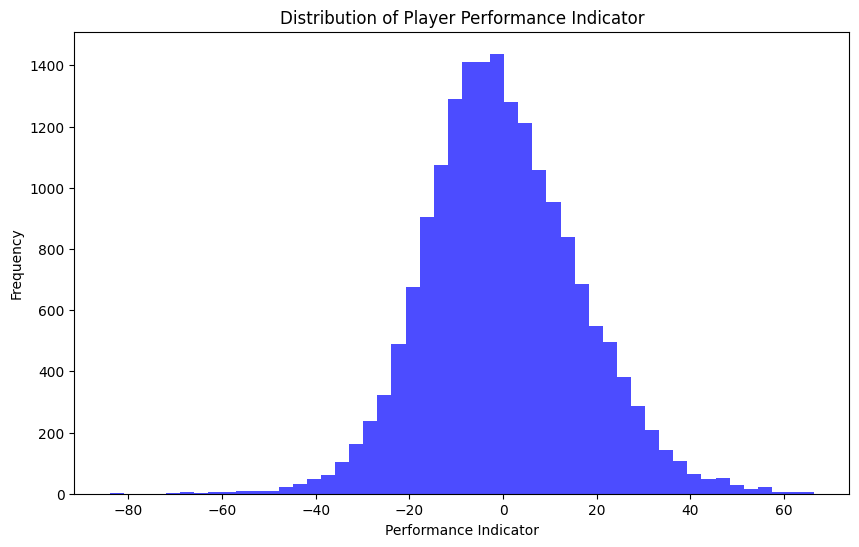

       performance
11687    66.430285
8831     64.919896
10295    64.350514
14756    63.904226
12651    63.803846
11152    63.641363
9258     63.421211
11641    62.914186
10171    62.156146
12137    62.016816


In [23]:

# Normalization
df_clean_normalized = df_clean[critical_columns].apply(lambda x: (x - x.mean()) / x.std())

# Assigning weights:
# Higher weights for critical stats like PTS, PER, WS, FG%, 2P%, 3P%, and MP.
# Lower weights for FGA, STL, TRB, DRB, FG, and FT%.
# Negative weight for TOV (turnovers) because it negatively affects performance.
weights = {
    'FG': 1, 'FGA': 0.5, 'FG%': 1.5, '3P%': 1.5, '2P%': 1.5, 'eFG%': 1.5,
    'FT%': 1, 'ORB': 1, 'DRB': 1, 'TRB': 1, 'AST': 1.5, 'STL': 1,
    'BLK': 1.5, 'TOV': -1, 'PTS': 1.8, 'MP': 1.5, 'PER': 2, 'WS': 2, 'WS/48': 1.8
}

# Calculating performance indicator
df_clean_normalized['performance'] = df_clean_normalized.apply(
    lambda row: sum(row[col] * weights[col] for col in critical_columns), axis=1
)

plt.figure(figsize=(10, 6))
plt.hist(df_clean_normalized['performance'], bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Player Performance Indicator')
plt.xlabel('Performance Indicator')
plt.ylabel('Frequency')
plt.show()

# Top 10 players based on performance
top_players = df_clean_normalized.nlargest(10, 'performance')
print(top_players[['performance']])

### 2.3 Hypothesis Tests

Examine the following hypothesis tests using the methods discussed in class, such as ANOVA, t-tests, A-B testing, Pearson and Spearman correlations. Make sure to provide p-values for each experiment and thoroughly justify your conclusions.

* Hypothesis 1: Player performance has significantly increased over time.

* Hypothesis 2: The average height and weight of NBA players has increased significantly over time.

* Hypothesis 3: Players from *Kentucky* college have a higher performance than players from other colleges.

* Hypothesis 4: There is a significant correlation between a player's height and their average points per game.

In [24]:
# H1

from scipy.stats import f_oneway, pearsonr, spearmanr
import matplotlib.pyplot as plt

# Adding Year column from df_clean to df_clean_normalized
df_clean_normalized['Year'] = df_clean['Year']

performance_by_year = df_clean_normalized.groupby('Year')['performance'].mean().dropna()

grouped_performance = [
    df_clean_normalized[df_clean_normalized['Year'] == year]['performance'].dropna()
    for year in df_clean_normalized['Year'].unique()
]

anova_result = f_oneway(*grouped_performance)

print("ANOVA Result for Performance by Year:")
print(f"F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}")

if anova_result.pvalue < 0.05:
    print("Performance has significantly changed over time (p < 0.05).")
else:
    print("No significant change in performance over time.")



ANOVA Result for Performance by Year:
F-statistic: 5.835620682296109, p-value: 3.0511392431469727e-30
Performance has significantly changed over time (p < 0.05).


Spearman Correlation: -0.7766073928591447, p-value: 9.307082379077693e-10
Pearson Correlation: -0.7152842239370836, p-value: 7.056176880354907e-08
Spearman correlation suggests a monotonic decrease in performance over time.
Pearson correlation suggests a linear decrease in performance over time.


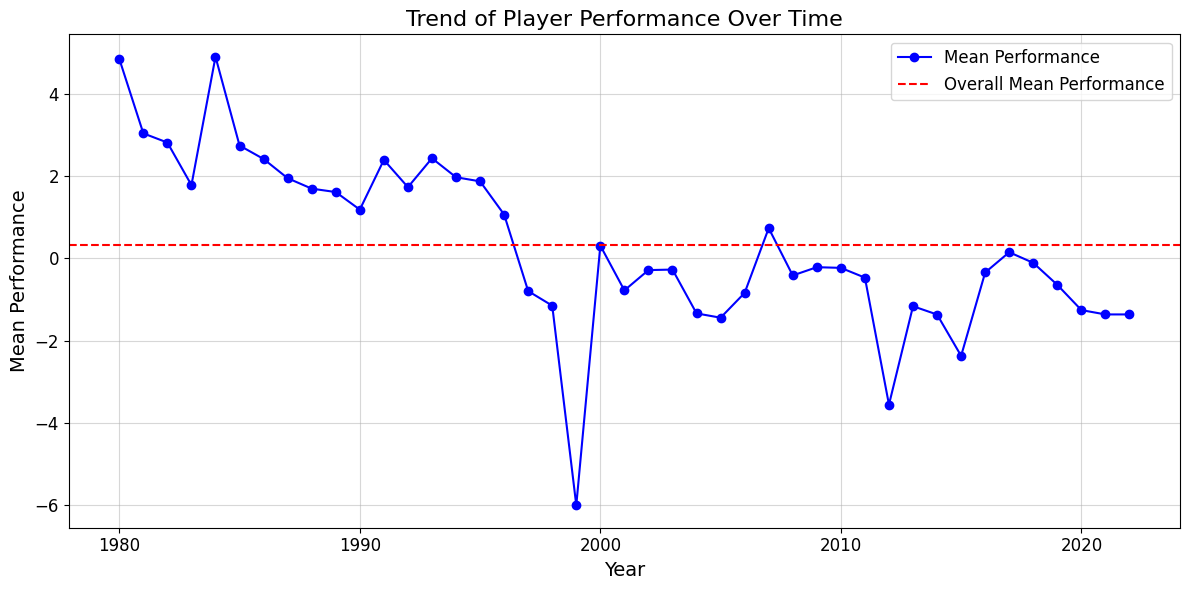

In [25]:
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt

spearman_corr, spearman_pvalue = spearmanr(performance_by_year.index, performance_by_year.values)
pearson_corr, pearson_pvalue = pearsonr(performance_by_year.index, performance_by_year.values)

print(f"Spearman Correlation: {spearman_corr}, p-value: {spearman_pvalue}")
print(f"Pearson Correlation: {pearson_corr}, p-value: {pearson_pvalue}")

if spearman_pvalue < 0.05:
    if spearman_corr > 0:
        print("Spearman correlation suggests a monotonic increase in performance over time.")
    elif spearman_corr < 0:
        print("Spearman correlation suggests a monotonic decrease in performance over time.")
    else:
        print("Spearman correlation suggests no monotonic relationship.")
else:
    print("Spearman correlation shows no significant monotonic relationship.")

if pearson_pvalue < 0.05:
    if pearson_corr > 0:
        print("Pearson correlation suggests a linear increase in performance over time.")
    elif pearson_corr < 0:
        print("Pearson correlation suggests a linear decrease in performance over time.")
    else:
        print("Pearson correlation suggests no linear relationship.")
else:
    print("Pearson correlation shows no significant linear relationship.")

plt.figure(figsize=(12, 6))
plt.plot(performance_by_year.index, performance_by_year.values, marker='o', color='blue', label='Mean Performance')
plt.axhline(performance_by_year.mean(), color='red', linestyle='--', label='Overall Mean Performance')

plt.title('Trend of Player Performance Over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Performance', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()


The small p-value (< 0.05) indicates that player performance significantly differs across the years.\
However, ANOVA only tells us that differences exist; it doesn't specify the direction (whether performance increased or decreased). 

Spearman's correlation coefficient suggests a strong negative monotonic relationship between performance and year. This means that as time progresses (from year to year), player performance tends to decrease, though not necessarily in a strictly linear fashion. The negative sign indicates a downward trend.

The p-value is very small, well below the 0.05 threshold, indicating that this result is statistically significant. This means we can confidently say that there is a significant monotonic decrease in player performance over time.

Pearson's correlation coefficient suggests a moderate to strong negative linear relationship between performance and year. This means that the performance not only tends to decrease as time progresses but also does so in a roughly linear manner. A negative value indicates that, on average, as the years increase, the performance decreases.

The p-value of is also very small, indicating that the result is statistically significant. This suggests that we can confidently conclude there is a significant linear decrease in player performance over time.

Both correlations are statistically significant (p-values much smaller than 0.05), so we can be confident in the conclusion that player performance has significantly decreased over time.

In [26]:
# H2

player_data_path = './data/Q2/player_data.csv'
player_data = pd.read_csv(player_data_path)

# Merging the performance data (df_clean) with player data (player_data) based on 'Player' column
merged_data = df_clean.merge(player_data[['Player', 'Ht', 'Wt']], on='Player', how='inner')

height_weight_data = merged_data[['Year', 'Ht', 'Wt']]
height_weight_data = height_weight_data.dropna(subset=['Year', 'Ht', 'Wt'])

height_weight_data.head()


,Year,Ht,Wt
0,1980,7-2,225.0
1,1980,6-7,220.0
2,1980,6-9,210.0
3,1980,6-1,150.0
4,1980,6-5,185.0


In [27]:
def height_to_inches(height):
    feet, inches = height.split('-')
    return int(feet) * 12 + int(inches)


height_weight_data['Ht_inch'] = height_weight_data['Ht'].apply(height_to_inches)

# Grouping by year, and performing ANOVA for Height and Weight
height_groups = [height_weight_data[height_weight_data['Year'] == year]['Ht_inch'] for year in height_weight_data['Year'].unique()]
weight_groups = [height_weight_data[height_weight_data['Year'] == year]['Wt'] for year in height_weight_data['Year'].unique()]

# ANOVA for height over years
anova_height = f_oneway(*height_groups)
print("ANOVA result for Height by Year:")
print(f"F-statistic: {anova_height.statistic}, p-value: {anova_height.pvalue}")

# ANOVA for weight over years
anova_weight = f_oneway(*weight_groups)
print("ANOVA result for Weight by Year:")
print(f"F-statistic: {anova_weight.statistic}, p-value: {anova_weight.pvalue}")

if anova_height.pvalue < 0.05:
    print("There is a significant difference in height over the years.")
else:
    print("No significant difference in height over the years.")

if anova_weight.pvalue < 0.05:
    print("There is a significant difference in weight over the years.")
else:
    print("No significant difference in weight over the years.")
    

ANOVA result for Height by Year:
F-statistic: 0.7062502559156651, p-value: 0.9237118507043063
ANOVA result for Weight by Year:
F-statistic: 18.01077885420438, p-value: 1.1504826009527737e-128
No significant difference in height over the years.
There is a significant difference in weight over the years.


In [28]:
# Spearman and Pearson correlation for Height
spearman_corr_height, spearman_p_value_height = spearmanr(height_weight_data['Year'], height_weight_data['Ht_inch'])
pearson_corr_height, pearson_p_value_height = pearsonr(height_weight_data['Year'], height_weight_data['Ht_inch'])

# Spearman and Pearson correlation for Weight
spearman_corr_weight, spearman_p_value_weight = spearmanr(height_weight_data['Year'], height_weight_data['Wt'])
pearson_corr_weight, pearson_p_value_weight = pearsonr(height_weight_data['Year'], height_weight_data['Wt'])

print(f"Spearman correlation for Height: {spearman_corr_height}, p-value: {spearman_p_value_height}")
print(f"Spearman correlation for Weight: {spearman_corr_weight}, p-value: {spearman_p_value_weight}")

print(f"Pearson correlation for Height: {pearson_corr_height}, p-value: {pearson_p_value_height}")
print(f"Pearson correlation for Weight: {pearson_corr_weight}, p-value: {pearson_p_value_weight}")


if spearman_p_value_height < 0.05:
    print("Spearman correlation suggests a significant monotonic relationship between year and height.")
else:
    print("No significant monotonic relationship between year and height.")

if spearman_p_value_weight < 0.05:
    print("Spearman correlation suggests a significant monotonic relationship between year and weight.")
else:
    print("No significant monotonic relationship between year and weight.")

if pearson_p_value_height < 0.05:
    print("Pearson correlation suggests a significant linear relationship between year and height.")
else:
    print("No significant linear relationship between year and height.")

if pearson_p_value_weight < 0.05:
    print("Pearson correlation suggests a significant linear relationship between year and weight.")
else:
    print("No significant linear relationship between year and weight.")

Spearman correlation for Height: -0.006433382201153396, p-value: 0.3970048602516597
Spearman correlation for Weight: 0.18831302871678796, p-value: 4.0861139051315526e-138
Pearson correlation for Height: -0.0031193459755585137, p-value: 0.6813129818754511
Pearson correlation for Weight: 0.19661843906736462, p-value: 1.248942472509007e-150
No significant monotonic relationship between year and height.
Spearman correlation suggests a significant monotonic relationship between year and weight.
No significant linear relationship between year and height.
Pearson correlation suggests a significant linear relationship between year and weight.


### Height:
The high p-value (greater than 0.05) indicates that there is no significant difference in player height across the years. This means that over time, the average height of players has remained relatively stable, and the observed variation is not statistically significant.

The very low Spearman correlation and the p-value greater than 0.05 indicate that there is no significant monotonic relationship between year and height. In other words, while the data may show some fluctuation, the relationship between the year and height is not monotonic, meaning height doesn’t consistently increase or decrease as time progresses.

The Pearson correlation close to zero, combined with the high p-value, suggests that there is no significant linear relationship between year and height. The lack of a significant linear trend indicates that height has not changed in a consistent, linear manner over time.

### Weight:
The extremely low p-value suggests that there is a significant difference in player weight across the years. This implies that player weight has undergone significant changes over time, and the variation in weight between different years is statistically significant.

The positive Spearman correlation suggests a weak monotonic increase in player weight over time, and the extremely low p-value indicates that this relationship is statistically significant. This means that over time, there is a slight but statistically significant trend for player weight to increase, even though the correlation is not strong.

The positive Pearson correlation suggests a weak linear increase in weight over time, and the extremely low p-value indicates a statistically significant linear relationship. This means that there is a consistent trend of increasing weight over the years, although the correlation is still relatively weak.

In conclusion, while player height has remained stable over time, player weight has shown a significant increase, both in terms of statistical differences across years and in the correlation trends.

In [29]:
# H3

from scipy.stats import ttest_ind

# Adding Player column from df_clean to df_clean_normalized using indices
df_clean_normalized['Player'] = df_clean['Player'].values

# Adding college information from player_data to the merged DataFrame
df_clean_normalized = df_clean_normalized.merge(player_data[['Player', 'Colleges']], on='Player', how='left')
df_clean_normalized = df_clean_normalized.dropna(subset=['Colleges'])

# Extracting Kentucky players and players from other colleges
kentucky_players = df_clean_normalized[df_clean_normalized['Colleges'].str.contains('Kentucky', case=False)]
other_colleges_players = df_clean_normalized[~df_clean_normalized['Colleges'].str.contains('Kentucky', case=False)]

# T-test for Performance between Kentucky and Other Colleges
t_statistic, p_value = ttest_ind(kentucky_players['performance'].dropna(), other_colleges_players['performance'].dropna())

print("T-test Result for Performance by College:")
print(f"T-statistic: {t_statistic}, p-value: {p_value}")

if p_value < 0.05:
    print("Performance of Kentucky players is significantly different from players of other colleges.")
else:
    print("No significant difference in performance between Kentucky players and players from other colleges.")

# Converting 'Colleges' to numerical values: 1 for Kentucky, 0 for others
df_clean_normalized['College_Kentucky'] = df_clean_normalized['Colleges'].apply(lambda x: 1 if x == 'Kentucky' else 0)



T-test Result for Performance by College:
T-statistic: 2.868242680370127, p-value: 0.004132930374079773
Performance of Kentucky players is significantly different from players of other colleges.


In [30]:
# Spearman and Pearson correlation for College vs Performance
spearman_corr_college, spearman_p_value_college = spearmanr(df_clean_normalized['College_Kentucky'], df_clean_normalized['performance'])
pearson_corr_college, pearson_p_value_college = pearsonr(df_clean_normalized['College_Kentucky'], df_clean_normalized['performance'])

print(f"Spearman correlation for College vs Performance: {spearman_corr_college}, p-value: {spearman_p_value_college}")
print(f"Pearson correlation for College vs Performance: {pearson_corr_college}, p-value: {pearson_p_value_college}")

if spearman_p_value_college < 0.05:
    print("Spearman correlation suggests a significant monotonic relationship between college and performance.")
else:
    print("No significant monotonic relationship between college and performance.")

if pearson_p_value_college < 0.05:
    print("Pearson correlation suggests a significant linear relationship between college and performance.")
else:
    print("No significant linear relationship between college and performance.")


Spearman correlation for College vs Performance: 0.03136173125215485, p-value: 6.661724286244667e-05
Pearson correlation for College vs Performance: 0.03062964962000917, p-value: 9.82323900845868e-05
Spearman correlation suggests a significant monotonic relationship between college and performance.
Pearson correlation suggests a significant linear relationship between college and performance.


C:\Users\LEGION\AppData\Local\Temp\ipykernel_12492\2756444614.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([kentucky_players['performance'].dropna(), other_colleges_players['performance'].dropna()], labels=['Kentucky', 'Other Colleges'])


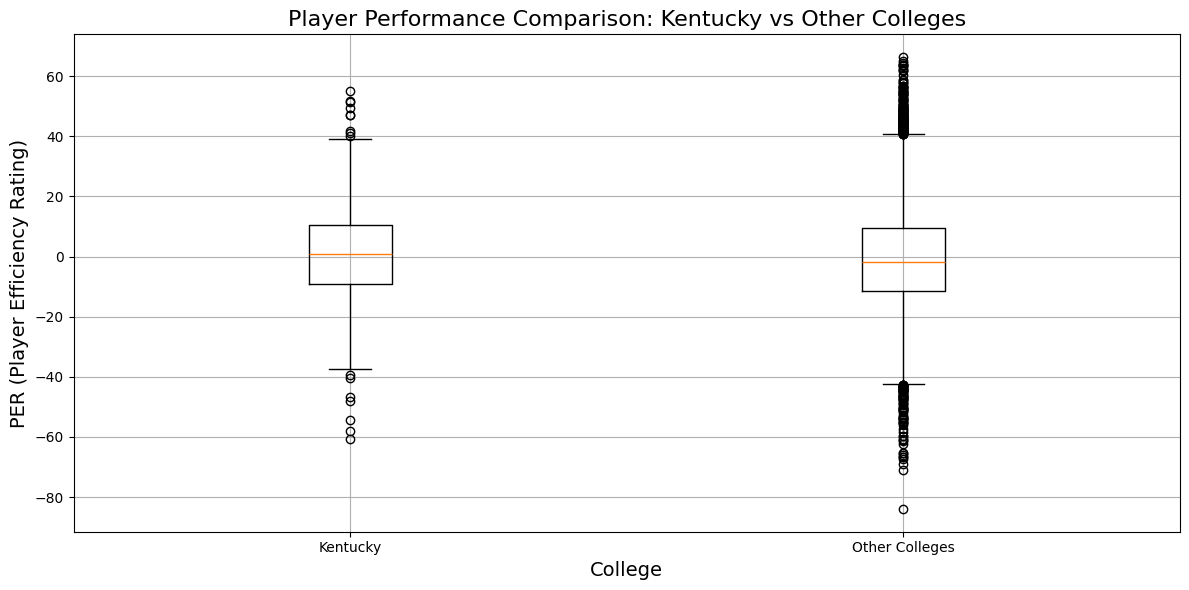

In [31]:
plt.figure(figsize=(12, 6))
plt.boxplot([kentucky_players['performance'].dropna(), other_colleges_players['performance'].dropna()], labels=['Kentucky', 'Other Colleges'])
plt.title('Player Performance Comparison: Kentucky vs Other Colleges', fontsize=16)
plt.ylabel('PER (Player Efficiency Rating)', fontsize=14)
plt.xlabel('College', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

The p-value is less than the significance level of 0.05, meaning the difference in performance between Kentucky players and players from other colleges is statistically significant. 
Therefore we can deduce that performance of Kentucky players is significantly different (better) from players of other colleges. This suggests that Kentucky players have a distinct performance pattern when compared to those from other colleges.

The Spearman correlation measures the strength and direction of a monotonic relationship between college affiliation and performance. The positive correlation value is small but significant, as indicated by the very low p-value, which is less than the 0.05 threshold.
So, here is a significant monotonic relationship between college and performance. This means that as college affiliation changes, there is a slight but statistically significant trend in performance. While the relationship is weak, it still exists.

The Pearson correlation assesses the strength and direction of a linear relationship between college and performance. Similar to the Spearman correlation, the Pearson correlation value is also small, but the p-value indicates a statistically significant relationship.Therefore there is a significant linear relationship between college and performance. Though the correlation is weak, it still shows a slight positive linear relationship, suggesting that college affiliation has some impact on performance.

In [32]:
# Comparing the means:


# Splitting players into two groups: Kentucky vs. other colleges
kentucky_players = df_clean_normalized[df_clean_normalized['Colleges'] == 'Kentucky']
other_colleges = df_clean_normalized[df_clean_normalized['Colleges'] != 'Kentucky']

# Calculating means
mean_kentucky_performance = kentucky_players['performance'].mean()
mean_other_colleges_performance = other_colleges['performance'].mean()

print(f"Mean Performance of Kentucky Players: {mean_kentucky_performance}")
print(f"Mean Performance of Other Colleges: {mean_other_colleges_performance}")


Mean Performance of Kentucky Players: 2.2078255543170235
Mean Performance of Other Colleges: -0.6897144273881959


The mean performance for Kentucky players is higher compared to players from other colleges. This suggests that, on average, Kentucky players perform better than players from other colleges.

In [33]:
# H4

from scipy.stats import spearmanr, pearsonr

df_clean.loc[:, 'PPG'] = df_clean['PTS'] / df_clean['G']
df_clean_with_height = df_clean.merge(player_data[['Player', 'Ht']], on='Player', how='left')
df_clean_with_height['Ht'] = df_clean_with_height['Ht'].apply(lambda height: height_to_inches(height) if isinstance(height, str) else None)

df_clean_with_height_clean = df_clean_with_height.dropna(subset=['Ht', 'PPG'])

# Spearman correlation (monotonic relationship)
spearman_corr_height_ppg, spearman_p_value = spearmanr(df_clean_with_height_clean['Ht'], df_clean_with_height_clean['PPG'])
print(f"Spearman correlation for Height vs PPG: {spearman_corr_height_ppg}, p-value: {spearman_p_value}")

# Pearson correlation (linear relationship)
pearson_corr_height_ppg, pearson_p_value = pearsonr(df_clean_with_height_clean['Ht'], df_clean_with_height_clean['PPG'])
print(f"Pearson correlation for Height vs PPG: {pearson_corr_height_ppg}, p-value: {pearson_p_value}")


Spearman correlation for Height vs PPG: 0.02812472523567044, p-value: 0.00021269915006214034
Pearson correlation for Height vs PPG: 0.044176510730482565, p-value: 5.926853148807793e-09


C:\Users\LEGION\AppData\Local\Temp\ipykernel_12492\2015891715.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[:, 'PPG'] = df_clean['PTS'] / df_clean['G']


Spearman correlation: The Spearman correlation for Height vs PPG is 0.0281, with a p-value of 0.00021. This suggests a very weak positive monotonic relationship between a player's height and their points per game (PPG). Despite the weak correlation, the p-value indicates that the relationship is statistically significant at the 0.05 level.

Pearson correlation: The Pearson correlation for Height vs PPG is 0.0442, with a p-value of 5.93e-09. This indicates a very weak positive linear relationship between height and PPG. The p-value is very small, suggesting that the relationship is statistically significant. However, the correlation value itself is very low, indicating a weak linear association.

Therefore, the correlations are statistically significant (p-values are very small), but the actual strength of the relationship is weak (correlation values are very close to 0).
The weak positive values suggest that height has a small, but statistically significant, effect on PPG, meaning that taller players might tend to score slightly more, but the effect is very minimal.